In [69]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly wordcloud

In [70]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing NumPy for working with arrays and performing numerical operations on large datasets
import numpy as np

# Importing the datetime module to handle date and time objects
import datetime as dt

# Importing matplotlibs pyplot module to create static visualizations
import matplotlib.pyplot as plt

# Importing the 3D plotting toolkit from Matplotlib to create 3 dimensional plots
from mpl_toolkits import mplot3d

# Importing Seaborn, a higher-level interface built on top of Matplotlib for creating statistical visualizations 
import seaborn as sns

# Importing the re module for regular expressions, used for string searching and manipulation 
import re

# Importing the preprocessing module from scikit learn, a machine learning library for scaling and normalizing data.
from sklearn import preprocessing

# Importing Plotlys graph_objects module for creating interactive, dynamic plots 
import plotly.graph_objects as go

# Importing the Sankey diagram tool from Matplotlib for visualizing flow and distribution of quantities using Sankey diagrams.
from matplotlib.sankey import Sankey

# Importing WordCloud and STOPWORDS from the wordcloud package to create word cloud visualizations 
from wordcloud import WordCloud, STOPWORDS

# Importing the warnings module to handle warnings and suppress unnecessary warning messages during execution.
import warnings
warnings.filterwarnings("ignore")  # Suppressing all warnings to avoid cluttering the output


In [71]:
###########################################################################################################
#                                    DATAFRAMES AND  GLOBAL VARIABLE CREATION
###########################################################################################################


#Step 1 : DATAFRAMES
data = pd.read_excel('V02Max_Combined.xlsx')
data_Kayaking = pd.read_excel("V02Max_Combined.xlsx", "Kayaking")
data_Athletes = pd.read_excel("V02Max_Combined.xlsx", "Athletes")
data_Triathlon = pd.read_excel("V02Max_Combined.xlsx", "Triathlon")
data_Fencing = pd.read_excel("V02Max_Combined.xlsx", "Fencing")

#Step 2 :DATAFRAME "data_Merged" Creation
#Concatenating all sport related table to one dataframe final_table
data_Merged=pd.concat([data_Fencing[['ID','time','RR','VO2','power']],
                       data_Kayaking[['ID','time','RR','VO2','power']],
                       data_Triathlon[['ID','time','RR','VO2','power']]],ignore_index=True)
#defining output excel file name
output='merged_athletes_data.xlsx'
#writing dataframe to excel using to_excel
data_Merged.to_excel(output,index=False)
#Reading the excel file back into dataframe for verification
data_Merged=pd.read_excel("merged_athletes_data.xlsx")


#Step 3 : DATAFRAME "data_Criteria" Creation
#define creteria data_Criteria = pd.read_excel("crieteria_data.xlsx")
warm_up_criteria = data_Merged['time'] <0
get_criteria = (data_Merged['time'] >= 0) & (data_Merged['power']>0)
# Apply the criteria to label the rows
data_Merged['phase'] = 'cool down'  # Default label, in case none of the criteria match
data_Merged.loc[warm_up_criteria, 'phase'] = 'Warm Up'
data_Merged.loc[get_criteria, 'phase'] = 'GET'
# Write the final creteria DataFrame to a new Excel file
output_file = 'crieteria_data.xlsx'
data_Merged.to_excel(output_file, index=False)
data_Criteria = pd.read_excel("crieteria_data.xlsx")


#Global variables
#-----------------------
#grouping the data and calculating VO2Sum for each athlete
df = data_Merged.groupby(['ID'])['VO2'].sum().reset_index(name = 'VO2_Sum')

#merging the data to fetch the weight of each athlete
df1 = pd.merge(df, data_Athletes[['ID','age','Weight','Height','sport','First Name','Last Name']], on='ID', how='inner')

#calculating VO2Max
df1['VO2Max'] = df1['VO2_Sum']/df1['Weight']


**1. VO2 vs. Power Output Relationship
   Findings:
   Power output increases, VO2 also increases.
   This relationship suggests that higher physical exertion (power output) results in higher oxygen consumption (VO2).**

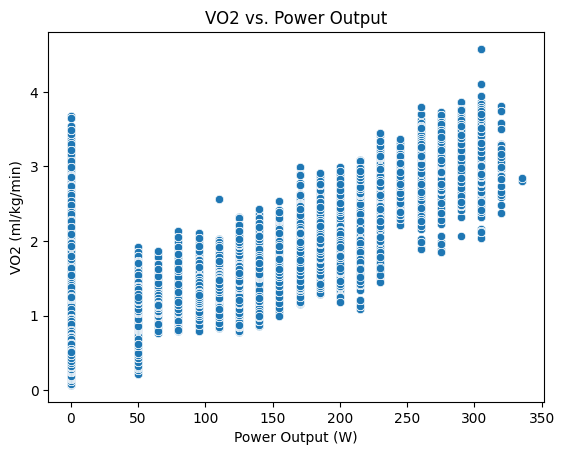

In [72]:
# Create a scatter plot with 'power' on the x-axis and 'VO2' on the y-axis using Seaborn
sns.scatterplot(x='power', y='VO2', data=data_Merged)
# Set the title of the plot
plt.title('VO2 vs. Power Output')
# Label the x-axis
plt.xlabel('Power Output (W)')
# Label the y-axis
plt.ylabel('VO2 (ml/kg/min)')
# Display the plot
plt.show()

**2.HR analysis(HR pattern)**

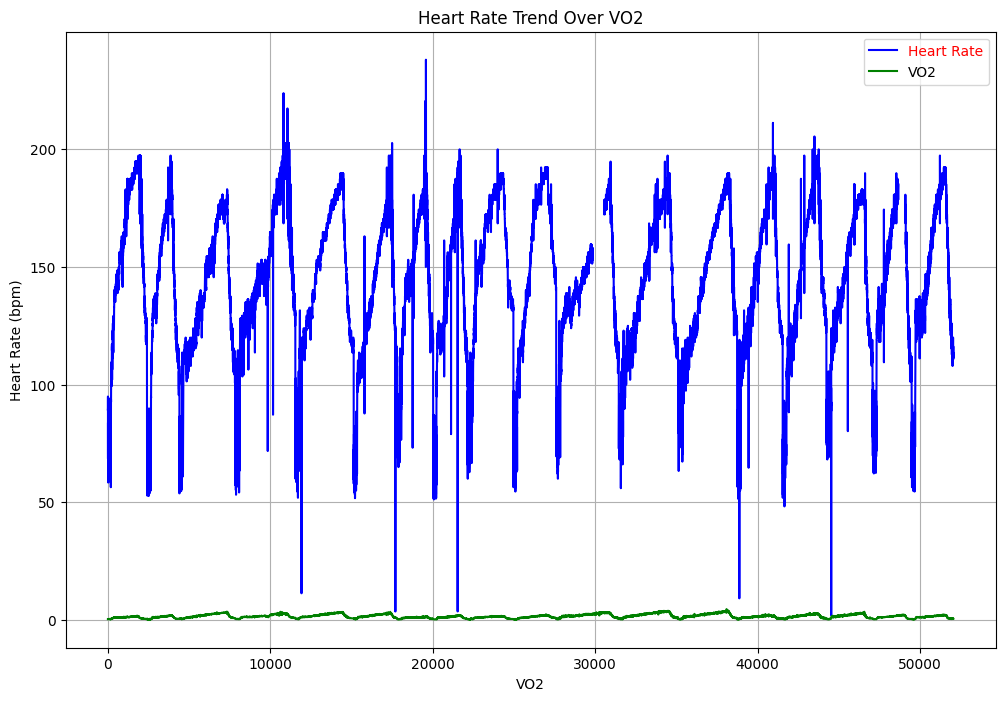

In [73]:
# Create a copy of the data_Merged DataFrame to avoid modifying the original data
copy_data_merged_sheet = data_Merged.copy()
# Calculate Heart Rate (HR) from RR intervals and add it as a new column to the copied DataFrame
copy_data_merged_sheet['HR'] = 60 / (copy_data_merged_sheet['RR'] / 1000)
# Set up the figure size for the plot
plt.figure(figsize=(12, 8))
# Plot Heart Rate versus index and VO2 versus VO2 on the same plot with different colors and labels
plt.plot(copy_data_merged_sheet.index, copy_data_merged_sheet['HR'], label='Heart Rate', color='blue')
plt.plot(copy_data_merged_sheet['VO2'], label='VO2', color='green')
# Set the title of the plot
plt.title('Heart Rate Trend Over VO2')
# Label the x-axis
plt.xlabel('VO2')
# Label the y-axis
plt.ylabel('Heart Rate (bpm)')
# Add a legend to the plot and set the color of the legend text for the first label
legend = plt.legend()
legend.get_texts()[0].set_color('red')
# Display a grid on the plot for better readability
plt.grid(True)
# Show the plot
plt.show()

**3.what is avg of power output between male and female athletes?**

In [74]:
#getting avg poer in male aand female
avg_power_gender=merged_athlete_sport.groupby('Gender')['power'].mean().reset_index()

#renaming coloums for better readability
avg_power_gender.columns = ['Gender', 'Average Power Output']

print(avg_power_gender.to_string(index=False))


Gender  Average Power Output
Female            104.502347
  Male            109.030776


Analysis: Male has more power output then female.

**4.How many athletes are out of  their safe heart rate limits during exercise?**

In [75]:
#calculating HR
merged_athlete = merged_athlete_sport.copy()
#merged_athlete_sport2=merged_athlete_sport
merged_athlete['HR']=60/(merged_athlete.RR/1000)
#Step 1 calculating Hr max from age
#keeping required columns
merged_athlete=merged_athlete[['ID','age','HR',]]
merged_athlete.loc[:, 'HR_max'] = 220 - merged_athlete['age']
#merged_athlete['HR_max'] = 220 - merged_athlete_sport2['age']
# Step 2: Define the safe heart rate limit as 85% of HR_max
merged_athlete['safe_HR_limit'] = 0.85 * merged_athlete['HR_max']
# Step 3: Identify when athletes exceed the safe heart rate limit
merged_athlete['exceeds_limit_safe_HR'] = merged_athlete['HR'] > merged_athlete['safe_HR_limit']
# Step 4: Identify the unique IDs of athletes who exceeded their safe HR limit
athletes_exceeded_HR = merged_athlete[merged_athlete['exceeds_limit_safe_HR']]['ID'].unique()
# Step 5: Count the number of unique athletes who exceeded their safe HR limit
num_athletes_exceeded_HR = len(athletes_exceeded_HR)
print ('count of Participants who exceeds safe heart rate limits:',num_athletes_exceeded_HR)

count of Participants who exceeds safe heart rate limits: 18


**5. Analyze the power at VT1 and VT2 across the sports**

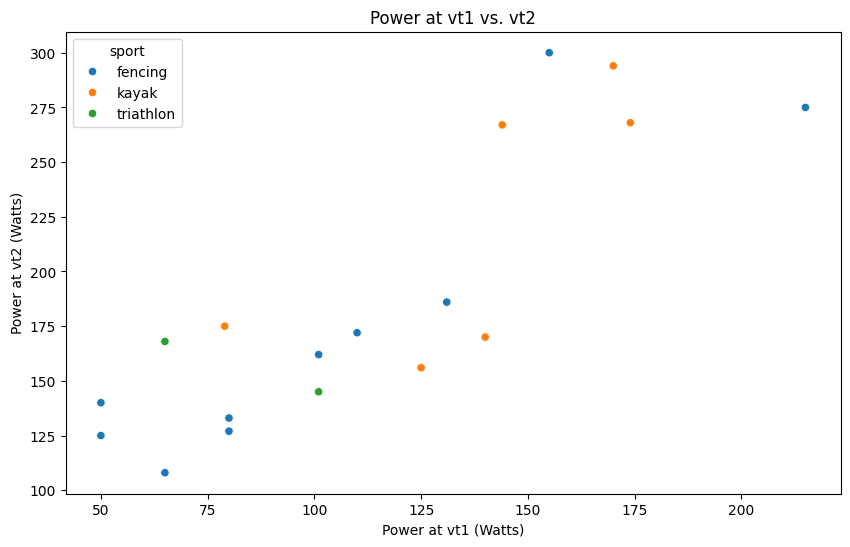

In [76]:
#copying the required data from Athletes sheet
sport_power_data = data_Athletes[['sport','P_vt1','P_vt2']]

#plotting the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x= 'P_vt1', y= 'P_vt2', hue='sport', data=sport_power_data)

#setting up the title and labels
plt.title('Power at vt1 vs. vt2')
plt.xlabel('Power at vt1 (Watts)')
plt.ylabel('Power at vt2 (Watts)')

#display the plot
plt.show()

Analysis: The above plot shows that there is a lot of variability in power outputs among athletes in fencing sport 
when compared to other sports. And also it shows that kayaking has the higher power outputs among all 
three sports.

**6. Which athlete has the least endurance level in terms of VO2.**

In [77]:
#grouping the data and calculating VO2Sum for each athlete
vo2_data = data_Merged.groupby(['ID'])['VO2'].sum().reset_index(name = 'VO2Sum')

#merging the data to fetch the weight of each athlete
req_data = pd.merge(vo2_data, data_Athletes[['ID','Weight','sport','First Name','Last Name']], 
                    on='ID', how='inner')

#calculating VO2Max
req_data['VO2Max'] = req_data['VO2Sum']/req_data['Weight']

#finding the athlete with least VO2 Max
vo2max_data = req_data[req_data['VO2Max'] == req_data['VO2Max'].min()]
athlete_ID = vo2max_data['ID'].values[0]
name = vo2max_data['First Name'] + ' ' + vo2max_data['Last Name']
athlete_name = name.values[0]

#printing the result
print(f"Athlete {athlete_name} with ID {athlete_ID} has the least endurance level in terms of VO2Max")

Athlete Grace Simmons with ID 7 has the least endurance level in terms of VO2Max


**7. Relationship between all the given variables of atheletes.**

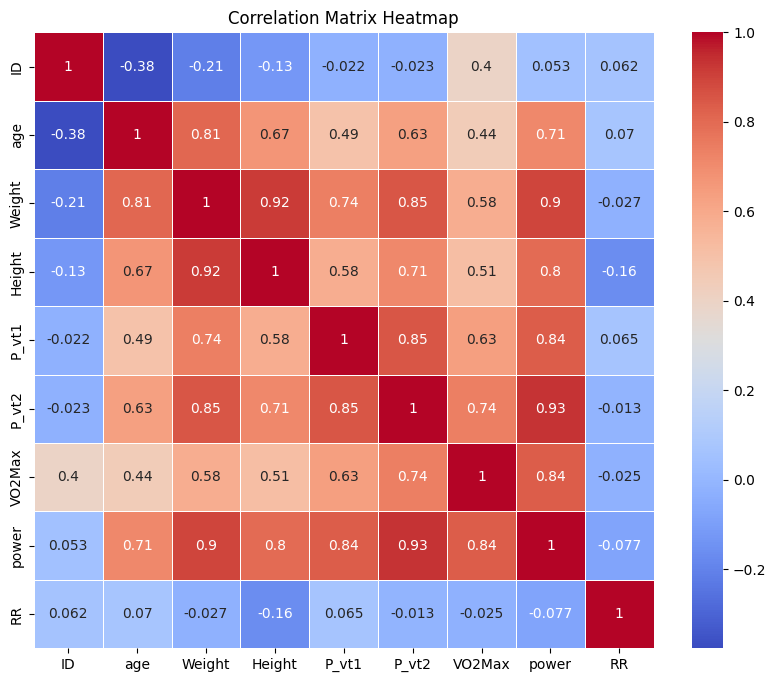

In [78]:
#copying athletes data into a dataframe
data  = data_Athletes[['ID','age','Weight','Height','P_vt1','P_vt2']]

#grouping the data and calculating VO2Sum for each athlete
vo2_data = data_Merged.groupby(['ID'])['VO2'].sum().reset_index(name = 'VO2Sum')

#merging the data to fetch the details of each athlete
vo2max_data = pd.merge(vo2_data, data_Athletes[['ID','Weight','sport','First Name','Last Name']], 
                     on='ID', how='inner')

#calculating VO2Max
vo2max_data['VO2Max'] = req_data['VO2Sum']/req_data['Weight']

#again merging the data we have with the vo2 max data to get vo2 max
all_data = pd.merge(data,vo2max_data[['ID','VO2Max']], on = 'ID', how = 'inner')

#grouping and merging the data to get power and RR from Merged dataset
merged_data = data_Merged.groupby(['ID'])[['power','RR']].mean().reset_index()
all_data = pd.merge(all_data,merged_data[['ID','power','RR']],on = 'ID', how = 'inner')

#correlation matrix 
corr_matrix = all_data.corr()

#showing the correlation with heat map
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

#setting up the title and displaying the plot
plt.title('Correlation Matrix Heatmap')
plt.show()


Analysis: In the above above plot it is evident that there is a positive correlation between the varables age, weight, height, power, P_vt1, P_vt2 and VO2Max. And negative correlation with respect to RR.

**8. Which sport has the highest average power output?**

In [79]:
#fetching sport data
sport_data = data_Athletes[['ID','sport']]

#fetching sum of power output for all the IDs
power_data = data_Merged.groupby(['ID'])['power'].sum().reset_index(name = 'power output')

#merging both the data based on ID column
merged_data = pd.merge(sport_data,power_data[['ID','power output']], on = 'ID', how = 'inner')

#calculating mean power output for each sport
final_data = merged_data.groupby(['sport'])['power output'].mean().reset_index(name = 'avgpoweroutput')

#finding the maximum avg power output
final_data = final_data[final_data['avgpoweroutput'] == final_data['avgpoweroutput'].max()]

#assigning the value to a variable
sport = final_data['sport'].values[0]

#printing the result
print(f"{sport} sport has the highest average power output among all the sports")

kayak sport has the highest average power output among all the sports
